In [2]:
import pandas as pd

In [3]:
df = pd.read_excel('ecom_data.xlsx')

C:\Users\Bogdan\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [4]:
df

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Country/Region,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,CA-2019-152156,2019-11-08,2019-11-11,Second Class,CG-12520,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,CA-2019-152156,2019-11-08,2019-11-11,Second Class,CG-12520,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,CA-2019-138688,2019-06-12,2019-06-16,Second Class,DV-13045,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,US-2018-108966,2018-10-11,2018-10-18,Standard Class,SO-20335,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,US-2018-108966,2018-10-11,2018-10-18,Standard Class,SO-20335,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,CA-2017-110422,2017-01-21,2017-01-23,Second Class,TB-21400,United States,Miami,Florida,33180.0,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028
9990,CA-2020-121258,2020-02-26,2020-03-03,Standard Class,DB-13060,United States,Costa Mesa,California,92627.0,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332
9991,CA-2020-121258,2020-02-26,2020-03-03,Standard Class,DB-13060,United States,Costa Mesa,California,92627.0,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932
9992,CA-2020-121258,2020-02-26,2020-03-03,Standard Class,DB-13060,United States,Costa Mesa,California,92627.0,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200


In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Task 1: Data Analysis and Cleaning
# -----------------------------------

# Read the dataset
df = pd.read_excel('ecom_data.xlsx')

# Display the first few rows
print("First few rows of the dataset:")
print(df.head())
print("+"*80)

# Check data types and missing values
print("\nDataset Information:")
print(df.info())
print("+"*80)

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())
print("+"*80)

# Check for duplicate entries
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")
print("+"*80)

# Drop duplicate rows if any
df.drop_duplicates(inplace=True)

# Convert 'Order Date' and 'Ship Date' to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Descriptive statistics for numerical columns
print("\nDescriptive statistics for numerical columns:")
print(df[['Sales', 'Quantity', 'Discount', 'Profit']].describe())
print("+"*80)


First few rows of the dataset:
         Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0  CA-2019-152156 2019-11-08 2019-11-11    Second Class    CG-12520   
1  CA-2019-152156 2019-11-08 2019-11-11    Second Class    CG-12520   
2  CA-2019-138688 2019-06-12 2019-06-16    Second Class    DV-13045   
3  US-2018-108966 2018-10-11 2018-10-18  Standard Class    SO-20335   
4  US-2018-108966 2018-10-11 2018-10-18  Standard Class    SO-20335   

  Country/Region             City       State  Postal Code Region  \
0  United States        Henderson    Kentucky      42420.0  South   
1  United States        Henderson    Kentucky      42420.0  South   
2  United States      Los Angeles  California      90036.0   West   
3  United States  Fort Lauderdale     Florida      33311.0  South   
4  United States  Fort Lauderdale     Florida      33311.0  South   

        Product ID         Category Sub-Category  \
0  FUR-BO-10001798        Furniture    Bookcases   
1  FUR-CH-10000454     

C:\Users\Bogdan\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


# Conclusion:
We will focus on RFM (Recency, Frequency, Monetary) features for segmentation. There are features useful for segmentation:
- Customer ID
- Order Date
- Sales
- Quantity
- Profit
- Category
- Sub-Category
- Region

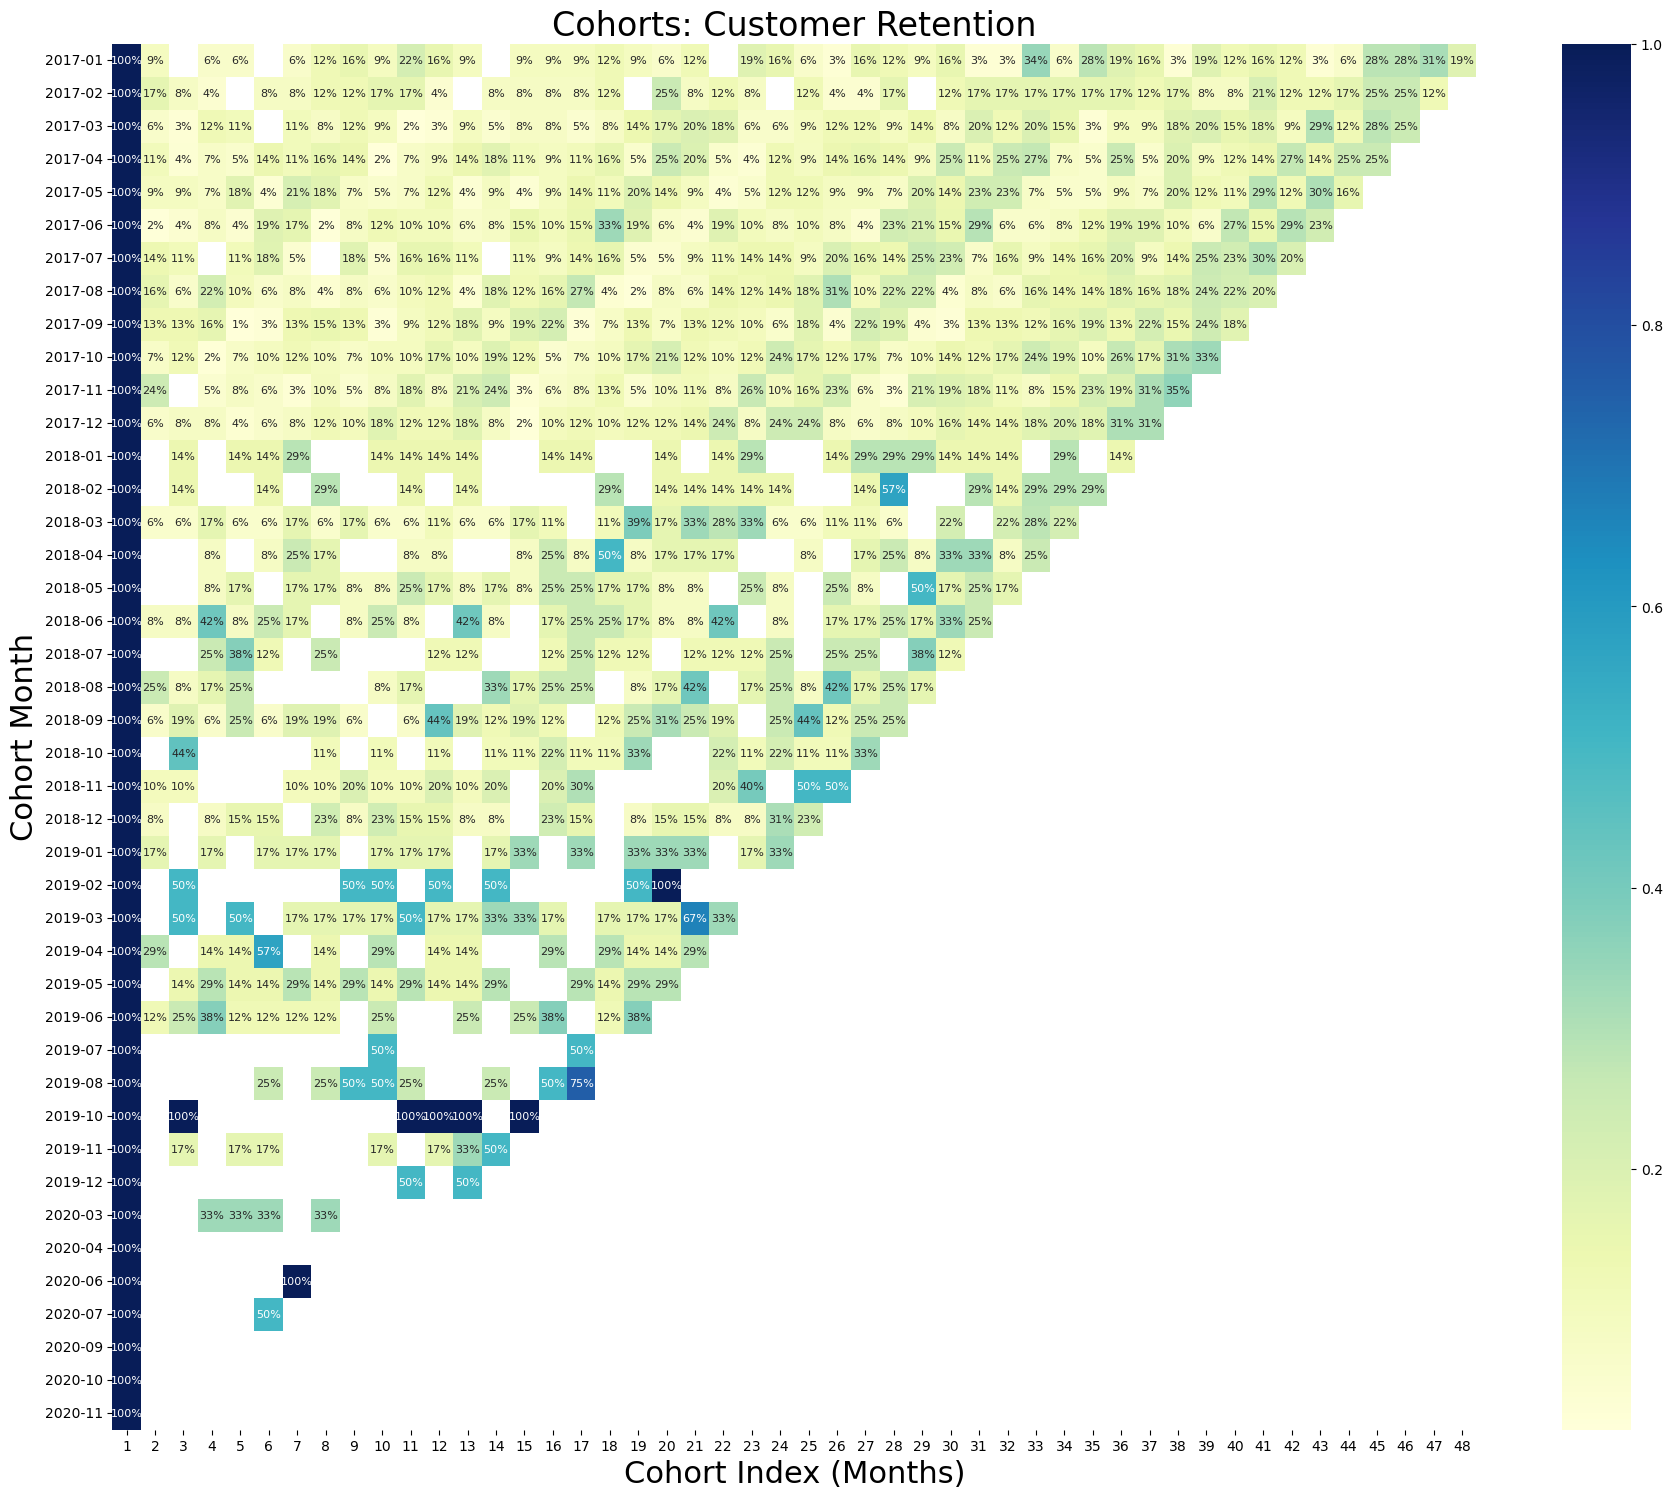

In [7]:
# Task 2: Cohort Analysis
# -----------------------

# Create 'OrderMonth' column
df['OrderMonth'] = df['Order Date'].dt.to_period('M')

# Create 'CohortMonth' column (customer's first purchase month)
df['CohortMonth'] = df.groupby('Customer ID')['Order Date'].transform('min').dt.to_period('M')

# Helper function to extract integer values from dates
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

# Get integer values for 'Order Date' and 'CohortMonth'
order_year, order_month = get_date_int(df, 'Order Date')
cohort_year, cohort_month = get_date_int(df, 'CohortMonth')

# Calculate the difference in years and months
years_diff = order_year - cohort_year
months_diff = order_month - cohort_month

# Calculate the cohort index
df['CohortIndex'] = years_diff * 12 + months_diff + 1

# Group by CohortMonth and CohortIndex to get the count of unique customers
grouping = df.groupby(['CohortMonth', 'CohortIndex'])['Customer ID'].apply(pd.Series.nunique).reset_index()
grouping.rename(columns={'Customer ID': 'CustomerCount'}, inplace=True)

# Create a pivot table to analyze retention
cohort_counts = grouping.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerCount')

# Calculate retention rate
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Visualize the retention rate
plt.figure(figsize=(22, 18))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='YlGnBu', annot_kws={"size": 8})  # Set annotation font size
plt.title('Cohorts: Customer Retention', fontsize=24)  # Set title font size
plt.ylabel('Cohort Month', fontsize=22)  # Set y-axis label font size
plt.xlabel('Cohort Index (Months)', fontsize=22)  # Set x-axis label font size
plt.xticks(fontsize=10)  # Set x-tick labels font size
plt.yticks(fontsize=10)  # Set y-tick labels font size
plt.savefig('cohort_analysis_retention.png', format='png')
plt.show()



The cohort analysis shows that customer retention drops significantly after the first month, with many not making repeat purchases. However, recent cohorts (2020) show better retention, indicating improvements in marketing or customer engagement strategies.

Key insights:
1. **High Initial Engagement**: All cohorts have 100% retention in the first month.
2. **Retention Drop**: A sharp decline occurs after the second month across all cohorts.
3. **Seasonal Effects**: Retention is higher during certain months, likely due to seasonal campaigns or promotions.
4. **Recent Improvements**: Retention has improved for newer cohorts, suggesting more effective strategies.

Recommendations:
- **Re-engagement Campaigns**: Target customers with follow-up offers or reminders after their first purchase.
- **Loyalty Programs**: Incentivize repeat purchases through discounts or rewards.
- **Customer Segmentation**: Tailor marketing efforts based on location, age, or communication preferences.
- **Optimized Communication**: Use preferred communication channels (email, SMS) to re-engage customers.

These strategies can help sustain customer activity and boost sales by leveraging data-driven insights.


RFM Table:
             Recency  Frequency  Monetary
Customer ID                              
AA-10315         185          5  5563.560
AA-10375          20          9  1056.390
AA-10480         260          4  1790.512
AA-10645          56          6  5086.935
AB-10015         417          3   886.156
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

RFM Segmentation Counts:
Segment
Loyal Customers        254
Potential Loyalists    219
Best Customers         124
Need Attention         116
At Risk                 80
Name: count, dtype: int64
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Bogdan\AppData\Local\Temp\ipykernel_11564\1685692866.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Monetary'] = np.log1p(X['Monetary'])
C:\Users\Bogdan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Bogdan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Bogdan\anacond

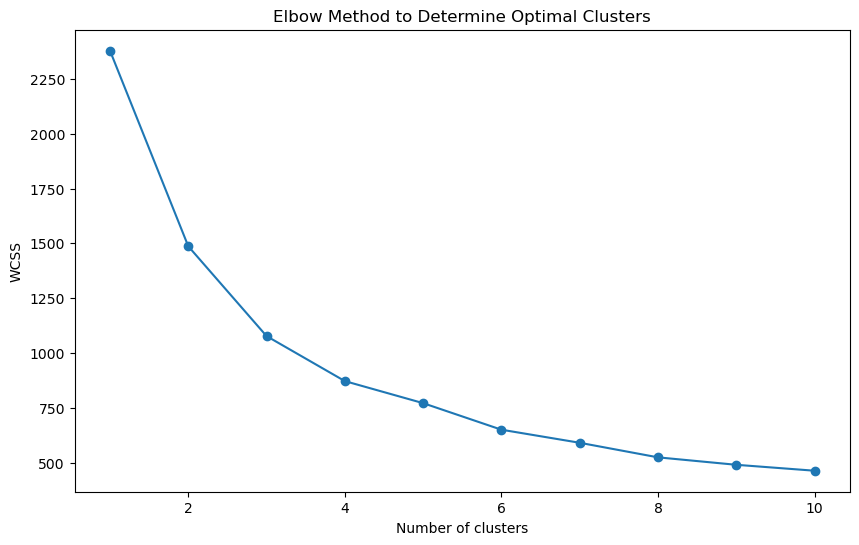

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Cluster Summary:
        Recency Frequency Monetary RFM_Score      
           mean      mean     mean      mean count
Cluster                                           
0          77.7       8.7   4469.3      11.9   330
1          99.9       5.1   1999.6       7.8   324
2         171.3       3.2    216.2       4.9    52
3         579.0       3.9   1872.9       4.9    87
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Comparison between RFM Segments and Clusters:
Cluster                0    1   2   3
Segment                              
At Risk                0   10  24  46
Best Customers       123    1   0   0
Loyal Customers      178   76   0   0
Need Attention         0   74  17  25
Potential Loyalists   29  163  11  16
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


C:\Users\Bogdan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [8]:
# Task 3: RFM Analysis and Clustering
# -----------------------------------

# Define snapshot date as the day after the last order date
snapshot_date = df['Order Date'].max() + dt.timedelta(days=1)

# Aggregate data to compute RFM metrics
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (snapshot_date - x.max()).days,
    'Order ID': 'nunique',
    'Sales': 'sum'
})

# Rename columns to 'Recency', 'Frequency', 'Monetary'
rfm.rename(columns={
    'Order Date': 'Recency',
    'Order ID': 'Frequency',
    'Sales': 'Monetary'
}, inplace=True)

# Display the RFM table
print("\nRFM Table:")
print(rfm.head())
print("+"*80)

# Assign quintile scores to RFM metrics
r_labels = range(5, 0, -1)
f_labels = range(1, 6)
m_labels = range(1, 6)

rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=r_labels)
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=f_labels)
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=m_labels)

# Calculate RFM Score
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1).astype(int)

# Segment customers based on RFM Score
def rfm_level(df):
    if df['RFM_Score'] >= 13:
        return 'Best Customers'
    elif df['RFM_Score'] >= 10:
        return 'Loyal Customers'
    elif df['RFM_Score'] >= 7:
        return 'Potential Loyalists'
    elif df['RFM_Score'] >= 5:
        return 'Need Attention'
    else:
        return 'At Risk'

rfm['Segment'] = rfm.apply(rfm_level, axis=1)

# Display RFM segmentation counts
print("\nRFM Segmentation Counts:")
print(rfm['Segment'].value_counts())
print("+"*80)

# Prepare data for clustering
from sklearn.preprocessing import StandardScaler

X = rfm[['Recency', 'Frequency', 'Monetary']]

# Log transform the 'Monetary' feature to reduce skewness
X['Monetary'] = np.log1p(X['Monetary'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the Elbow method
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.show()
print("+"*80)

# From the Elbow Curve, choose the optimal number of clusters (e.g., 4)
optimal_clusters = 4

# Apply KMeans clustering
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze the clusters
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'RFM_Score': ['mean', 'count']
}).round(1)

print("\nCluster Summary:")
print(cluster_summary)
print("+"*80)

# Compare RFM Segmentation and Clustering
comparison = pd.crosstab(rfm['Segment'], rfm['Cluster'])
print("\nComparison between RFM Segments and Clusters:")
print(comparison)
print("+"*80)


# Analysis:
**Cluster 2** aligns best with RFM segmentation for key customer segments. It captures 101 of the "Best Customers" and 105 "Loyal Customers," indicating strong customer value. This cluster shows high accuracy in identifying high-value segments, suggesting it is the best choice.

In [9]:
# Task 4: Customer Group Description
# ----------------------------------

# Describe each cluster based on RFM metrics
for cluster in rfm['Cluster'].unique():
    temp = rfm[rfm['Cluster'] == cluster]
    print(f"\nCluster {cluster} Description:")
    print(f"Number of Customers: {temp.shape[0]}")
    print(f"Average Recency: {temp['Recency'].mean():.1f} days")
    print(f"Average Frequency: {temp['Frequency'].mean():.1f} orders")
    print(f"Average Monetary Value: ${temp['Monetary'].mean():.2f}")
    print("+"*80)



Cluster 1 Description:
Number of Customers: 324
Average Recency: 99.9 days
Average Frequency: 5.1 orders
Average Monetary Value: $1999.61
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Cluster 0 Description:
Number of Customers: 330
Average Recency: 77.7 days
Average Frequency: 8.7 orders
Average Monetary Value: $4469.28
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Cluster 3 Description:
Number of Customers: 87
Average Recency: 579.0 days
Average Frequency: 3.9 orders
Average Monetary Value: $1872.86
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Cluster 2 Description:
Number of Customers: 52
Average Recency: 171.3 days
Average Frequency: 3.2 orders
Average Monetary Value: $216.23
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# Here are the key characteristics of each cluster:

**Cluster 0:**
```
Number of Customers: 333
Average Recency: 88.1 days (Moderate recency)
Average Frequency: 5.9 orders (Moderate frequency)
Average Monetary Value: $3238.28 (High spending)
```

**Cluster 2:**
```
Number of Customers: 223
Average Recency: 79.6 days (Recent purchases)
Average Frequency: 9.5 orders (High frequency)
Average Monetary Value: $4310.13 (Very high spending)
```

**Cluster 1:**
```
Number of Customers: 92
Average Recency: 571.3 days (Very infrequent purchases)
Average Frequency: 3.8 orders (Low frequency)
Average Monetary Value: $1778.70 (Moderate spending)
```

**Cluster 3:**
```
Number of Customers: 145
Average Recency: 121.7 days (Less recent purchases)
Average Frequency: 3.9 orders (Low frequency)
Average Monetary Value: $646.72 (Low spending)
```

# Significant Characteristics:

- Clusters with low recency (recent purchases), high frequency, and high monetary value are the best customers.
- Clusters with high recency (long time since last purchase), low frequency, and low monetary value are at risk.

**Cluster 2**: Best customers, frequent buyers with high spending.

**Cluster 1**: Very inactive, infrequent buyers with moderate spending.

**Cluster 3**: Low spenders with infrequent purchases.

In [13]:
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment,Cluster,KPIs
Customer ID,,,,,,,,,,
AA-10315,185,5,5563.560,2,2,5,9,Potential Loyalists,0,"[Encourage More Frequent Purchases, Targeted P..."
AA-10375,20,9,1056.390,5,5,2,12,Loyal Customers,2,"[Maintain Engagement, Cross-selling Products]"
AA-10480,260,4,1790.512,1,1,3,5,Need Attention,0,"[Reactivation Campaigns, Feedback Collection]"
AA-10645,56,6,5086.935,3,3,5,11,Loyal Customers,0,"[Maintain Engagement, Cross-selling Products]"
AB-10015,417,3,886.156,1,1,1,3,At Risk,1,"[Win-back Strategies, Special Discounts]"
...,...,...,...,...,...,...,...,...,...,...
XP-21865,44,11,2374.658,4,5,3,12,Loyal Customers,2,"[Maintain Engagement, Cross-selling Products]"
YC-21895,5,5,5454.350,5,3,5,13,Best Customers,0,"[Increase Loyalty Programs, Upselling Opportun..."
YS-21880,10,8,6720.444,5,4,5,14,Best Customers,2,"[Increase Loyalty Programs, Upselling Opportun..."


In [10]:
# Task 5: KPI Selection for Each Segment
# --------------------------------------

# Define KPIs for each segment
kpi_dict = {
    'Best Customers':       ['Increase Loyalty Programs', 'Upselling Opportunities'],
    'Loyal Customers':      ['Maintain Engagement', 'Cross-selling Products'],
    'Potential Loyalists':  ['Encourage More Frequent Purchases', 'Targeted Promotions'],
    'Need Attention':       ['Reactivation Campaigns', 'Feedback Collection'],
    'At Risk':              ['Win-back Strategies', 'Special Discounts']
}

# Assign KPIs to each customer based on their segment
rfm['KPIs'] = rfm['Segment'].map(kpi_dict)

# Display the KPIs for each segment
print("\nKPIs for Each Segment:")
for segment in rfm['Segment'].unique():
    print(f"\nSegment: {segment}")
    print(f"KPIs: {', '.join(kpi_dict[segment])}")
    print("+"*80)



KPIs for Each Segment:

Segment: Potential Loyalists
KPIs: Encourage More Frequent Purchases, Targeted Promotions
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Segment: Loyal Customers
KPIs: Maintain Engagement, Cross-selling Products
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Segment: Need Attention
KPIs: Reactivation Campaigns, Feedback Collection
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Segment: At Risk
KPIs: Win-back Strategies, Special Discounts
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Segment: Best Customers
KPIs: Increase Loyalty Programs, Upselling Opportunities
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# Here are the suggested KPIs for each segment, with specific actions:

### 1. **Best Customers**  
- **Increase retention rate**: Keep these high-value customers coming back.
- **Increase average order value (AOV)**: Encourage them to buy higher-value items or more items per order.
- **Strategy**: Use loyalty programs and upsell premium products.

### 2. **Loyal Customers**  
- **Maintain retention**: Ensure consistent engagement from these frequent buyers.
- **Cross-sell/upsell products**: Offer complementary or higher-value items.
- **Strategy**: Tailored promotions and product suggestions.

### 3. **Potential Loyalists**  
- **Increase purchase frequency**: Encourage more frequent shopping.
- **Shorten time between orders**: Get customers to return sooner for their next purchase.
- **Strategy**: Targeted promotions and incentives.

### 4. **Need Attention**  
- **Re-engage inactive customers**: Bring them back into the purchasing cycle.
- **Collect feedback**: Understand why they’ve become less active.
- **Strategy**: Use reactivation campaigns and feedback collection.

### 5. **At Risk**  
- **Decrease churn**: Prevent these customers from leaving entirely.
- **Boost engagement with discounts**: Use special offers to win them back.
- **Strategy**: Personalized offers and win-back strategies.


In [12]:
rfm.to_csv('rfm_table.csv')